In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown

from src.load_data import DataLoaderFactory
from src.plot_data_basic import Plotter, PlotStrategy
from src.plot_data_basic import PlotAverageSessionTimes, PlotNumberOfSessions, PlotUserFrequencyDistribution
from src.plot_data_univariate import PlotCategoricalDistribution, PlotNumericalDistribution
from src.plot_data_bivariate import PlotNumericalVsNumericalScatter, PlotCorrHeatmap, PlotCategoricalVsNumericalBox

from src.eda_tools import plot_bivariate_plots, plot_univariate_plots
from src.plot_tools import add_enriched_datetime_columns, get_daily_session_stats
from src.utils import setup_logger

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plotter = Plotter(PlotStrategy)

dataset_id = "ACN_Caltech"

setup_logger(os.path.join("log",f"{dataset_id.lower()}.log"), level="INFO")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [309]:
# Load the data
loader = DataLoaderFactory.get_loader(
        dataset_id,
        force_download=False
    )
df_raw: pd.DataFrame = loader.load()
df_original = add_enriched_datetime_columns(df_raw)
display(df_original.head(5))
display(df_original.tail(5))

print("\nData Types and Non-null Counts:")
print(df_original.info())


,EV_id_x,start_datetime,end_datetime,total_energy,month,day_of_week,day_of_week_enum,duration_minutes,date,start_time,end_time
0,EV0,2018-04-25 04:08:04,2018-04-25 06:20:10,7.932,April,Wednesday,2,132.100000,2018-04-25,04:08:04,06:20:10
1,EV1,2018-04-25 06:45:10,2018-04-25 17:56:16,10.013,April,Wednesday,2,671.100000,2018-04-25,06:45:10,17:56:16
2,EV2,2018-04-25 06:45:50,2018-04-25 16:04:45,5.257,April,Wednesday,2,558.916667,2018-04-25,06:45:50,16:04:45
3,EV3,2018-04-25 07:37:06,2018-04-25 16:55:34,5.177,April,Wednesday,2,558.466667,2018-04-25,07:37:06,16:55:34
4,EV4,2018-04-25 07:40:34,2018-04-25 16:03:12,10.119,April,Wednesday,2,502.633333,2018-04-25,07:40:34,16:03:12


,EV_id_x,start_datetime,end_datetime,total_energy,month,day_of_week,day_of_week_enum,duration_minutes,date,start_time,end_time
31419,EV12628,2021-09-13 14:12:53,2021-09-13 17:25:36,2.285,September,Monday,0,192.716667,2021-09-13,14:12:53,17:25:36
31420,EV15113,2021-09-13 14:17:04,2021-09-13 18:01:49,6.715,September,Monday,0,224.750000,2021-09-13,14:17:04,18:01:49
31421,EV14390,2021-09-13 15:33:07,2021-09-13 16:06:55,17.720,September,Monday,0,33.800000,2021-09-13,15:33:07,16:06:55
31422,EV12596,2021-09-13 16:11:12,2021-09-13 18:43:11,2.018,September,Monday,0,151.983333,2021-09-13,16:11:12,18:43:11
31423,EV15588,2021-09-13 18:52:37,2021-09-13 20:05:10,45.064,September,Monday,0,72.550000,2021-09-13,18:52:37,20:05:10



Data Types and Non-null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31424 entries, 0 to 31423
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   EV_id_x           31424 non-null  object        
 1   start_datetime    31424 non-null  datetime64[ns]
 2   end_datetime      31424 non-null  datetime64[ns]
 3   total_energy      31424 non-null  float64       
 4   month             31424 non-null  object        
 5   day_of_week       31424 non-null  object        
 6   day_of_week_enum  31424 non-null  int32         
 7   duration_minutes  31424 non-null  float64       
 8   date              31424 non-null  object        
 9   start_time        31424 non-null  object        
 10  end_time          31424 non-null  object        
dtypes: datetime64[ns](2), float64(2), int32(1), object(6)
memory usage: 2.5+ MB
None


### EV Arrival Patterns

**Number of EV Arrivals per Month**  
   This bar chart displays the monthly counts of EV arrivals across the original dataset.  
   - Activity is highest between **mid-2018 and late 2018**, reaching a peak of around **2,400 sessions per month**.  
   - After early 2019, arrivals stabilize at a lower level, generally between **800 and 1,000 sessions per month**.  
   - There is a significant **drop in arrivals after February 2020**, which coincides with the start of the COVID-19 pandemic, followed by a slow recovery into 2021.  

These visualizations provide insight into the temporal patterns of EV charging usage, highlighting the initial growth, stabilization, and pandemic-related decline in activity.


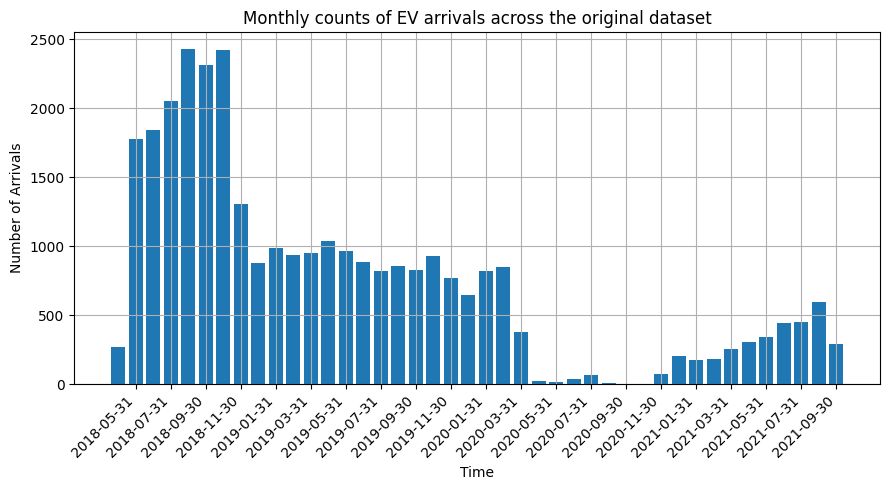

In [310]:
fig, ax = plt.subplots(figsize=(9, 5))
plotter.set_strategy(PlotNumberOfSessions(frequency='ME', max_xticks= 20))
fig = plotter.plot(df_original, ax=ax)
ax.set_title("Monthly counts of EV arrivals across the original dataset")
plt.show()

### Data Cleaning Steps

The dataset initially contained **31,424 charging sessions**, spanning from **2018-04-25** to **2021-09-13**.

1. **Remove sessions after February 2020**  
   To exclude the period impacted by the COVID-19 pandemic, all charging sessions that occurred **after February 2020** will be removed.  
   *This step removed approximately **14.9%** of the data.*

2. **Remove excessively long sessions**  
   To ensure only typical charging behavior is analyzed, all sessions where an EV remained connected for **more than 24 hours** will be removed.  
   *This step removed approximately **0.9%** of the remaining sessions.*

After these cleaning steps, **26,496 (84.3%) sessions** remain for analysis.



In [311]:
df = df_original
total_sessions = df.shape[0]

# Count sessions after the cutoff_date (2020-02-01)
cutoff_date = pd.to_datetime("2020-02-01")
after_cutoff_date = df["start_datetime"] >= cutoff_date
portion_after_cutoff_date = 100 * after_cutoff_date.sum() / total_sessions

display(Markdown(f"""
Total number of sessions: {total_sessions}.<br>
Remove the sessions occurred **after Feb 2020** (COVID-19 pandemic) -> **{after_cutoff_date.sum()} sessions**.
"""))

df_v1 = df[(df["start_datetime"] < cutoff_date)].copy()



Total number of sessions: 31424.<br>
Remove the sessions occurred **after Feb 2020** (COVID-19 pandemic) -> **4687 sessions**.


In [312]:
df = df_v1
total_sessions = df.shape[0]

long_stay_minutes = 24*60
count_long_stay = (df['duration_minutes'] > (long_stay_minutes)).sum()
portion_long_stay = 100 * count_long_stay / total_sessions

display(Markdown(f"""
Total number of remaining sessions: {total_sessions}.<br>
Remove the sessions stayed longer than {long_stay_minutes/60:.0f} hours -> **{count_long_stay} sessions**.
"""))

df_v2 = df[df['duration_minutes'] <= (long_stay_minutes)].copy()



Total number of remaining sessions: 26737.<br>
Remove the sessions stayed longer than 24 hours -> **241 sessions**.


In [317]:
df_cleaned = df_v2
total_sessions_original = df_original.shape[0]
total_sessions_cleaned = df_cleaned.shape[0]
display(Markdown(f"""
Total number of remaining sessions: {total_sessions_cleaned} ({100*total_sessions_cleaned/total_sessions_original:.1f}%).
"""))


Total number of remaining sessions: 26496 (84.3%).


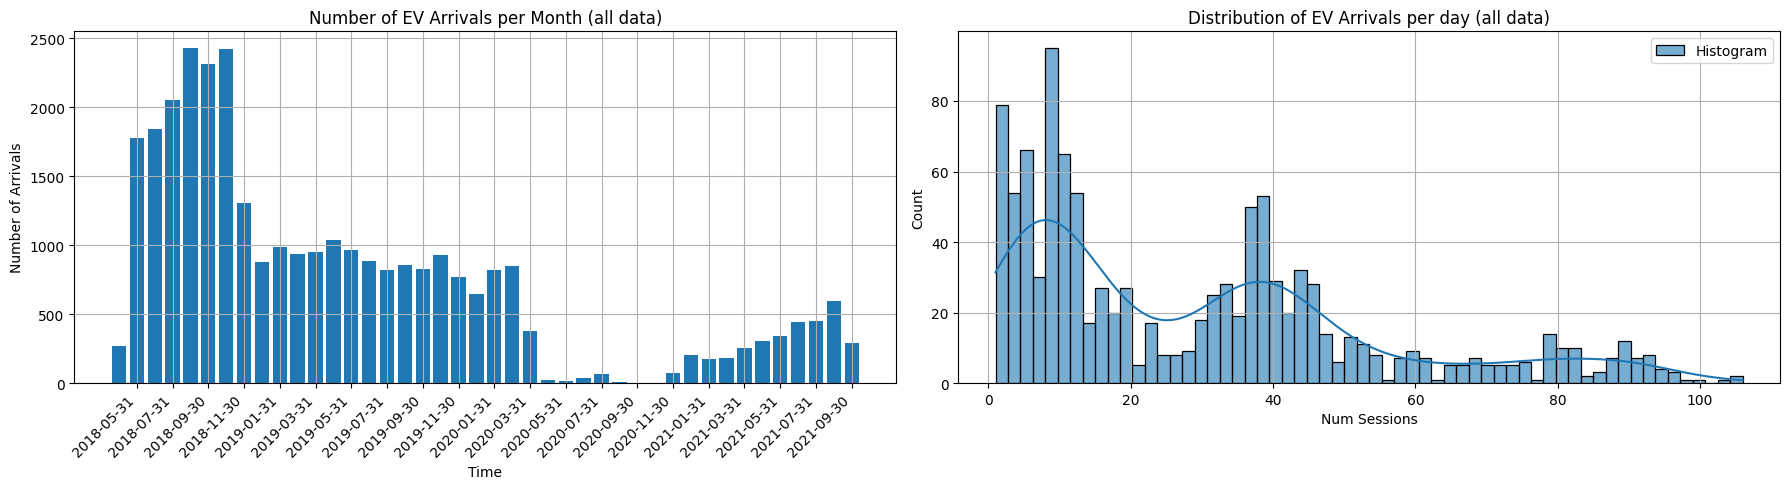

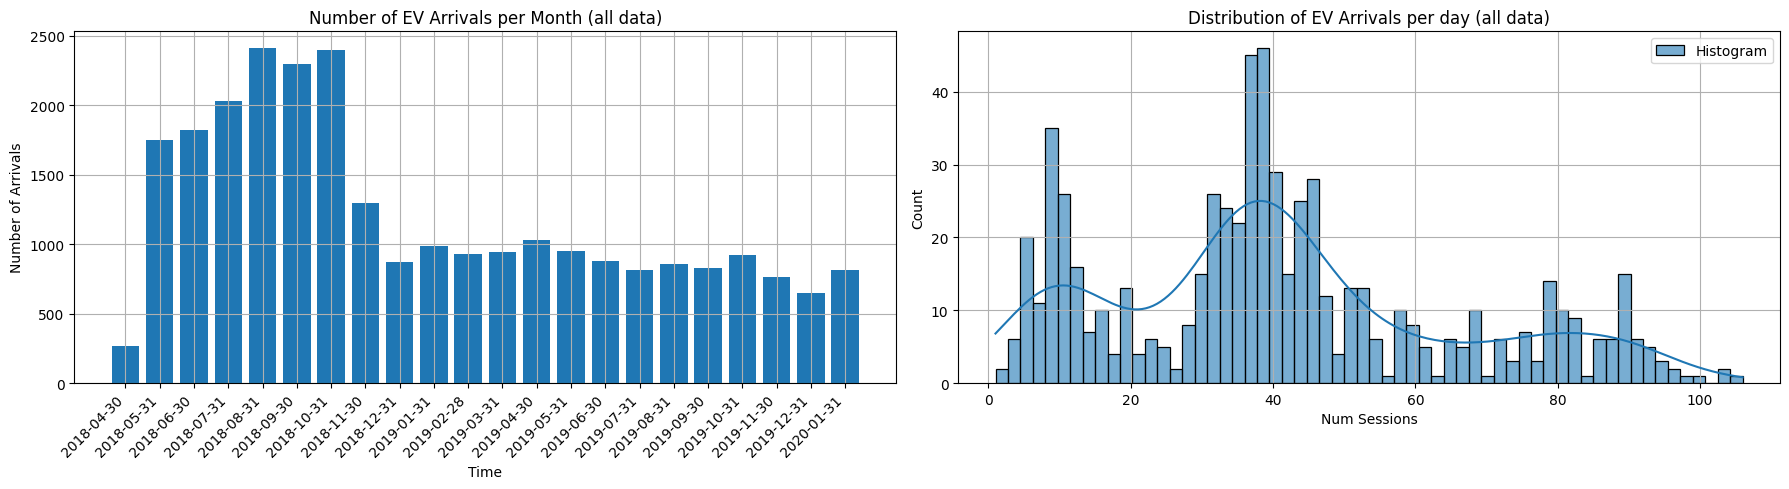

In [314]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
plotter.set_strategy(PlotNumberOfSessions(frequency='ME', max_xticks= 20))
fig = plotter.plot(df_original, ax= axs[0])
fig.axes[0].set_title("Number of EV Arrivals per Month (all data)")

plotter.set_strategy(PlotNumericalDistribution(kde=True))
plotter.plot(get_daily_session_stats(df_original), column="num_sessions", bins=60, ax=axs[1])
fig.axes[1].set_title("Distribution of EV Arrivals per day (all data)")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
plotter.set_strategy(PlotNumberOfSessions(frequency='ME', max_xticks= 20))
fig = plotter.plot(df_cleaned, ax= axs[0])
fig.axes[0].set_title("Number of EV Arrivals per Month (all data)")

plotter.set_strategy(PlotNumericalDistribution(kde=True))
plotter.plot(get_daily_session_stats(df_cleaned), column="num_sessions", bins=60, ax=axs[1])
fig.axes[1].set_title("Distribution of EV Arrivals per day (all data)")
plt.show()

### EV Arrival Patterns After Data Cleaning

The figure above compares the distribution of EV charging sessions **before and after applying data-cleaning steps** (removing post–February 2020 data and sessions longer than 24 hours):

1. **Number of EV Arrivals per Month (left)**  
   - After cleaning, the dataset primarily covers activity from **mid-2018 through early 2020**.  
   - Monthly arrivals are **more stable** compared to the raw dataset, generally between **600 and 2,400 sessions per month**, indicating two distinct usage patterns. 
   - The large drop in arrivals after early 2020 (observed in the raw data) is no longer present, as those months were excluded.  

2. **Distribution of EV Arrivals per Day (right)**  
   - The cleaned data maintains the **bimodal distribution**, with peaks at approximately **10 sessions/day** and **35–40 sessions/day**.  
   - A small number of days exhibit **high activity (>80 sessions)**, suggesting occasional events or peak demand periods.  

In summary, data cleaning resulted in providing a more consistent dataset for analyzing typical EV charging behaviors.


Unique users: 14757
Users with only one sessions: 14457 (98.0%) of the users account for 54.6% of all sessions.


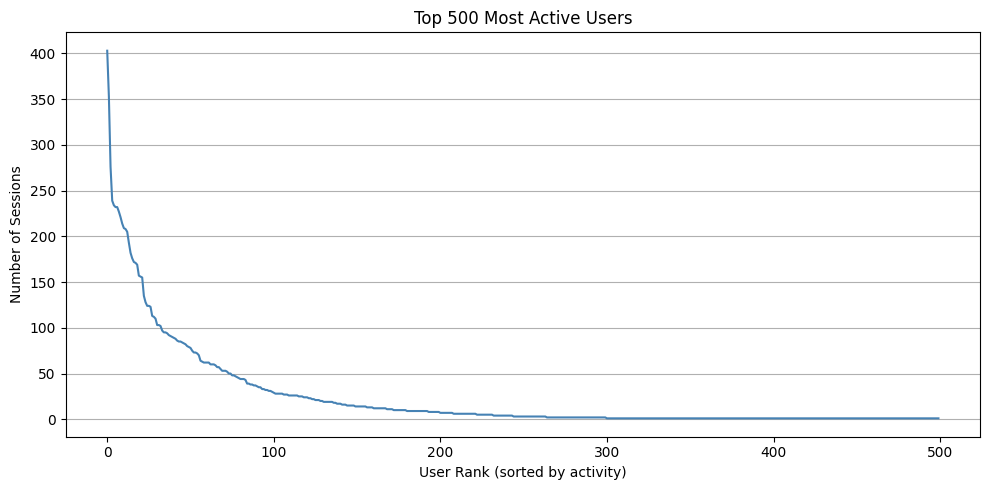

In [332]:
# Number of unique users
unique_users = df_cleaned['EV_id_x'].nunique()

# Session counts per user
sessions_per_user = df_cleaned['EV_id_x'].value_counts()

print(f"Unique users: {unique_users}")

mask = sessions_per_user == 1
only_one = mask.sum()
percentage_only_one = (only_one / unique_users) * 100
print(f"Users with only one sessions: {only_one} ({percentage_only_one:.1f}%) of the users account for {100*sessions_per_user.loc[mask].sum()/sessions_per_user.sum():.1f}% of all sessions.")


plotter.set_strategy(PlotUserFrequencyDistribution())
fig, _ = plotter.plot(df_cleaned, top_n = 500)


### Activity of the Top 500 Most Active Users

The figure above shows the distribution of the **top 500 most active EV users**, ranked by their number of charging sessions:

- The most active user recorded **over 400 sessions**, with a steep drop in activity after the top few users.
- The distribution is **highly skewed (long-tail)** since there are **14,757 users**.

However, **this pattern is misleading**. Approximately **98% of the sessions do not have associated user IDs** and are therefore treated as unique, one-off users. This artificially inflates the number of low-activity “users” and creates a misleading picture of engagement.  

As a result, **user-level analysis in this dataset is not meaningful**, even though some users appear to have high activity.


### Exploring Dataset Distributions

In the following sections, we present key **categorical** and **numerical** distributions related to the dataset.  
These visualizations help uncover patterns in usage behavior, session characteristics, and other important features of the EV charging data.

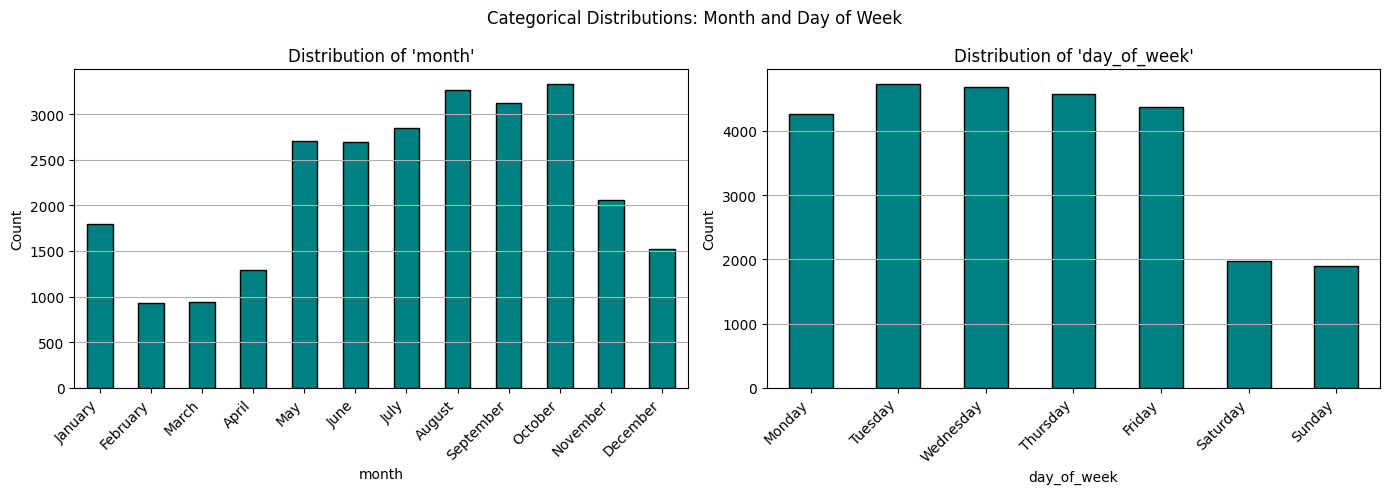

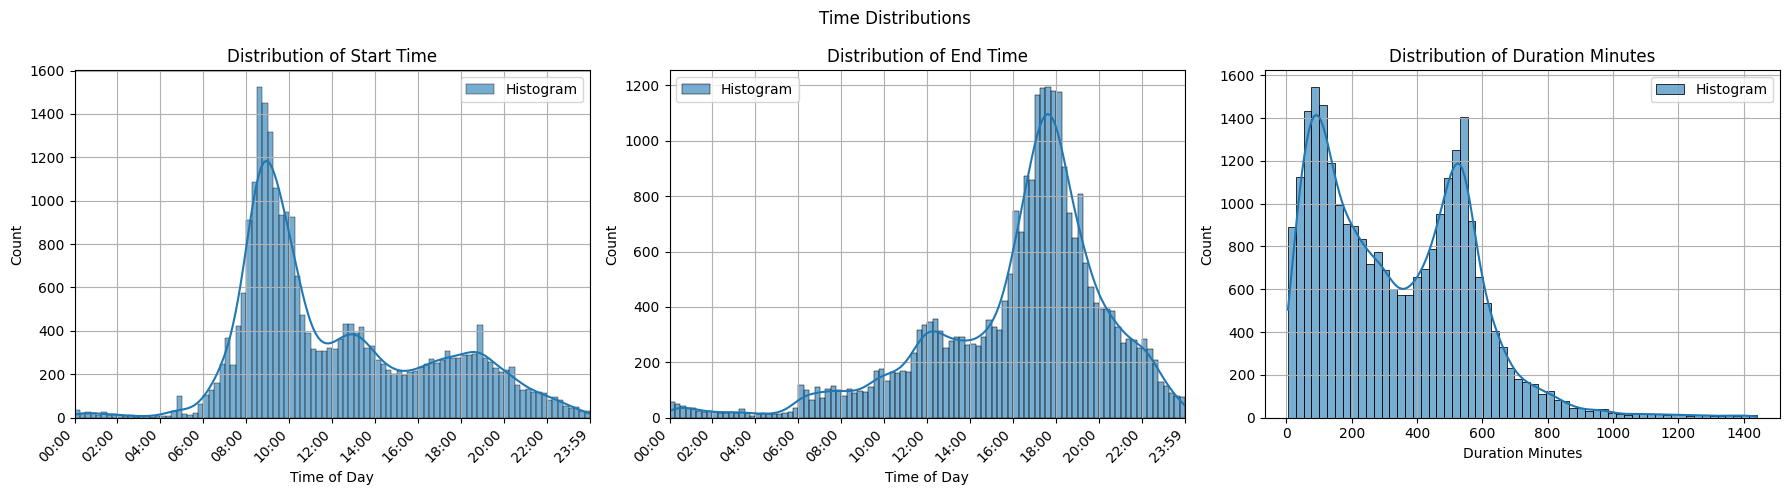

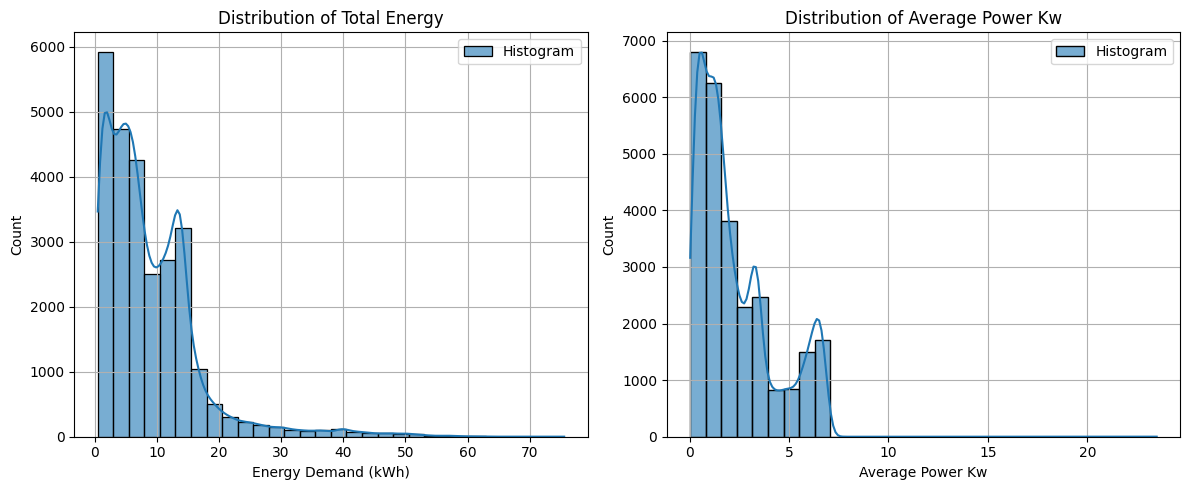

In [316]:
plot_univariate_plots(plotter, df_cleaned)

### Bivariate Analysis

Next, we explore **bivariate relationships** within the dataset to better understand how variables interact with each other.  
This includes visualizations such as **correlation heatmaps**, and **2D histograms** to examine joint distributions of key variables.  

**Note:** Some EVs **stay connected overnight**, which leads to patterns that may initially appear unusual. However, these behaviors are valid.


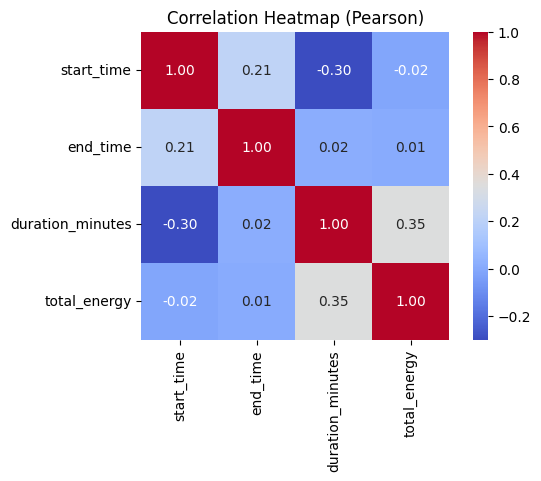

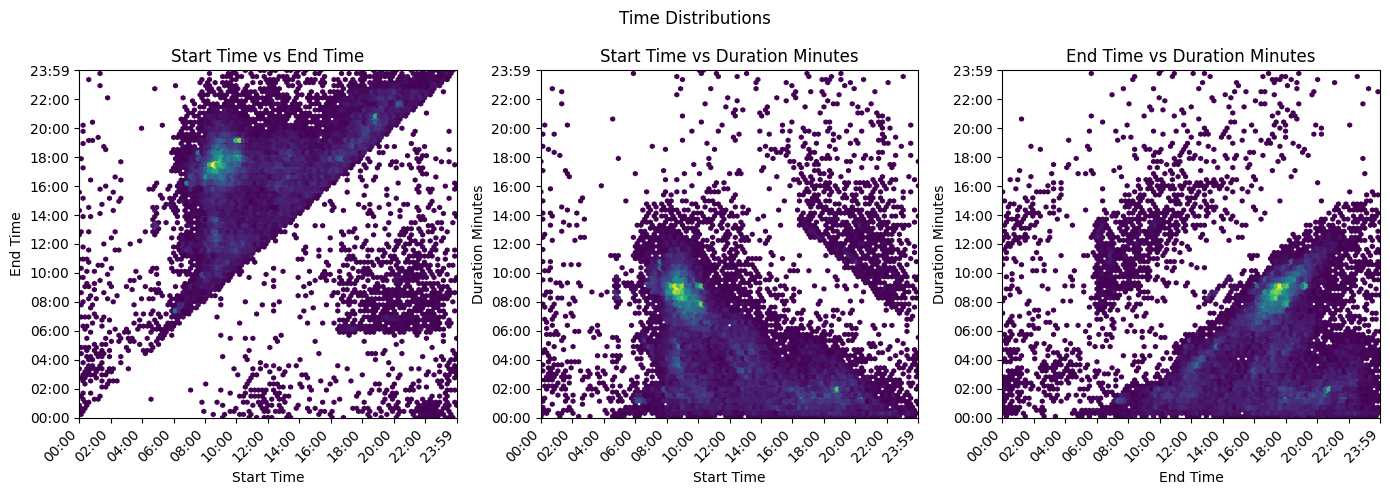

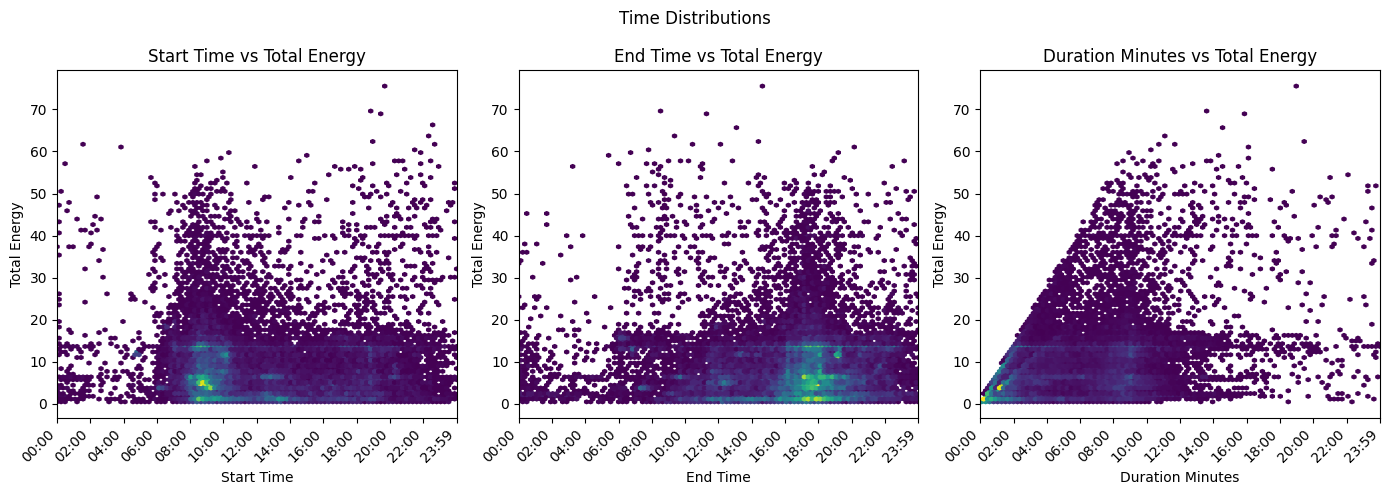

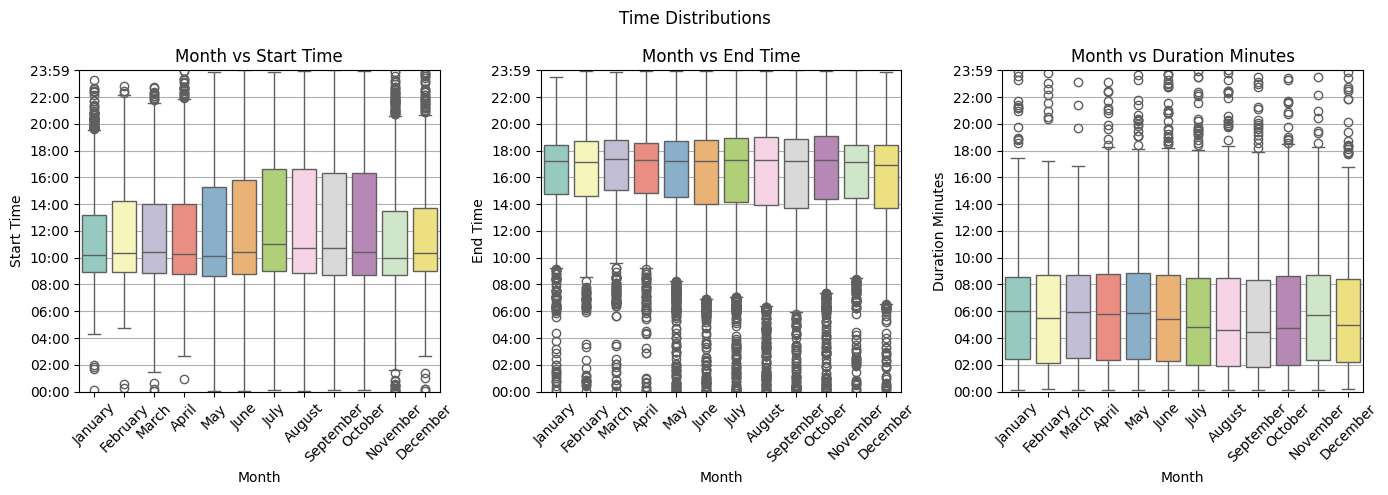

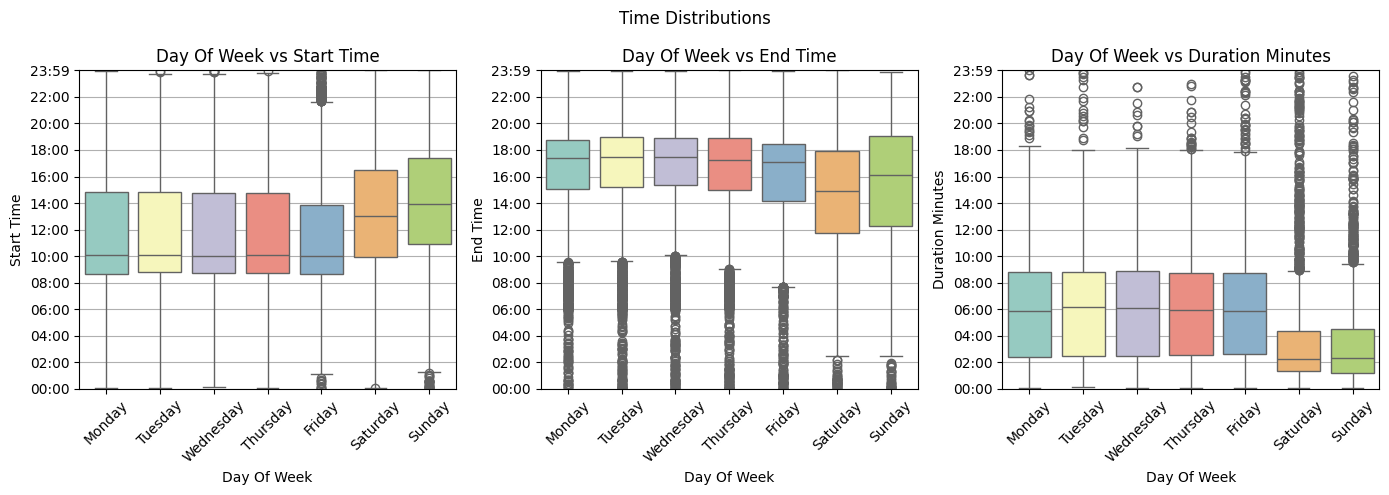

In [301]:
plot_bivariate_plots(plotter, df_cleaned)

### Bivariate Analysis (exluding sessions that stay connected overnight)


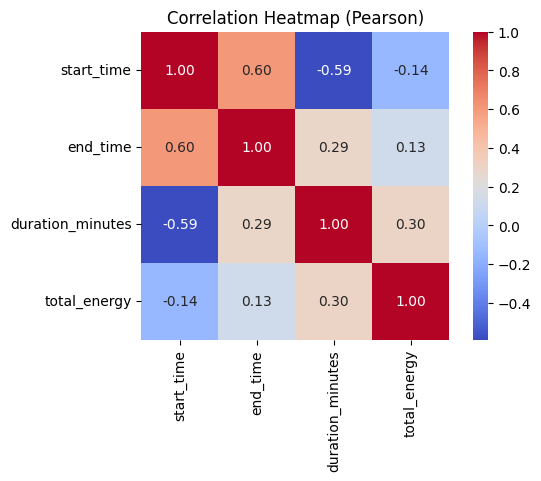

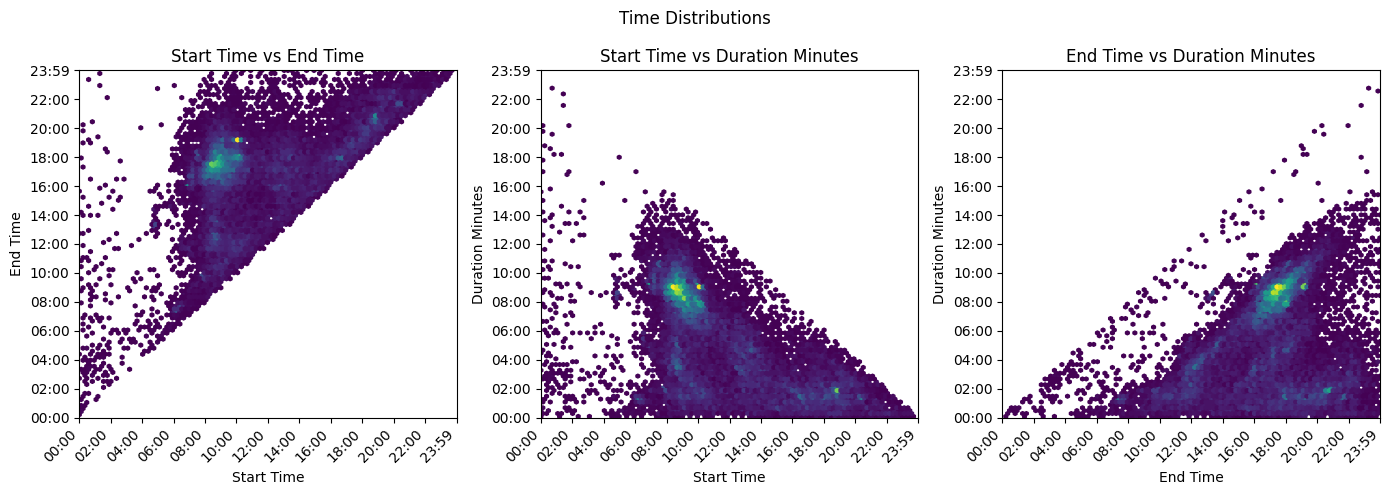

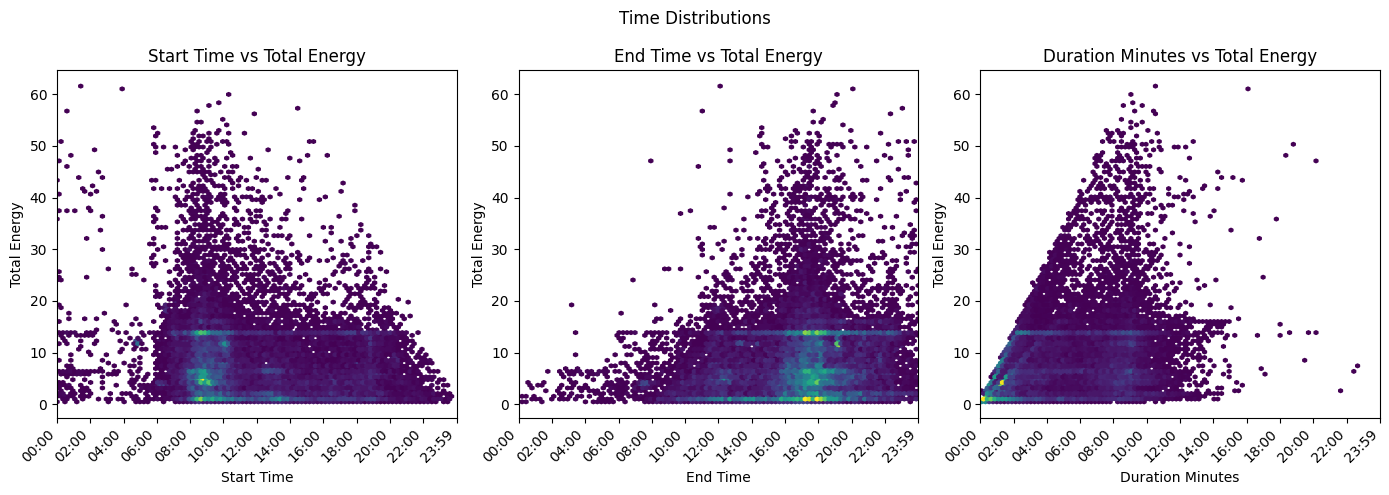

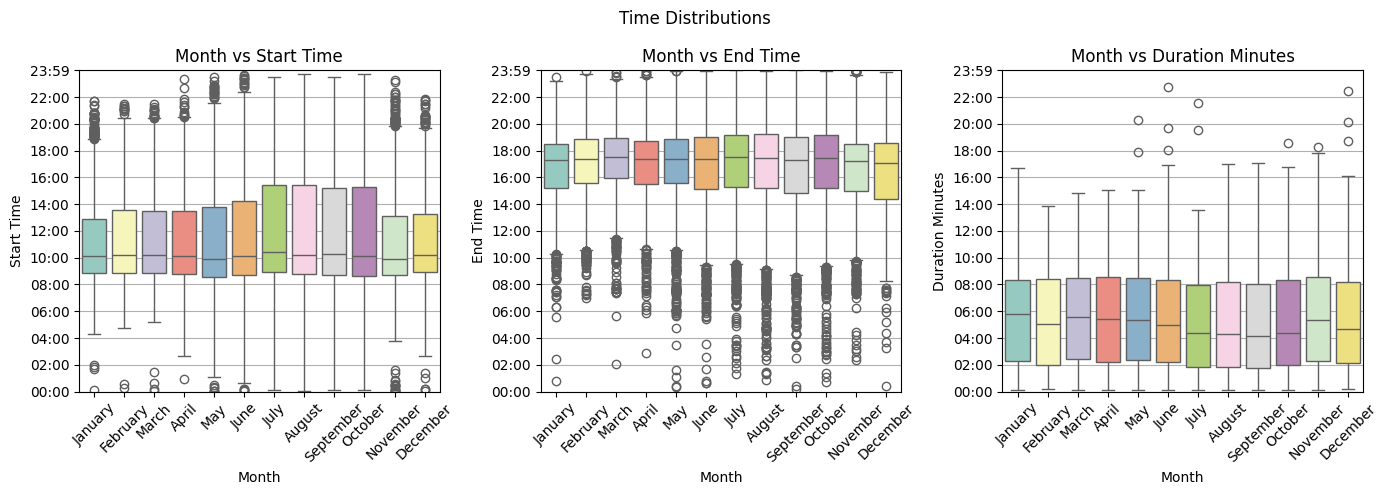

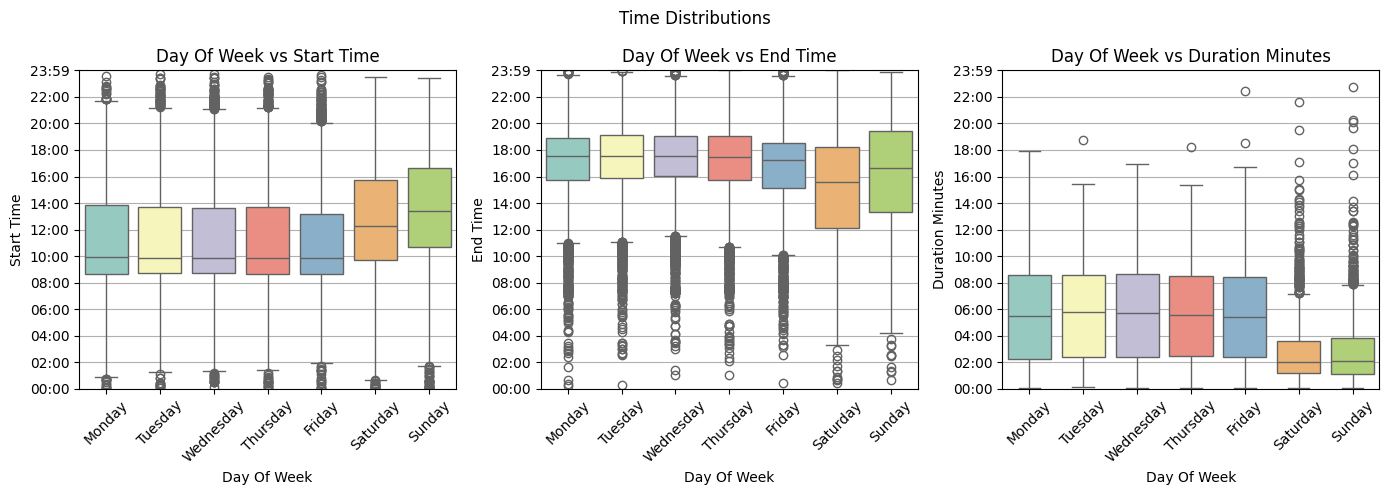

In [306]:
df_cleaned["is_overnight"] = df_cleaned["start_datetime"].dt.date != df_cleaned["end_datetime"].dt.date
df_cleaned_no_overnight = df_cleaned.loc[~df_cleaned["is_overnight"]].copy()
plot_bivariate_plots(plotter,df_cleaned_no_overnight)